# Analisis de sentimientos

## Carga de librerias

In [62]:
import os
from string import punctuation

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import pandas as pd

from src.features.build_features import processing_text_pipeline
from src.features.processing_text import remove_tokens
from src.visualization.exploratory_text import top_frec
from src.visualization.visualize import confusion_matrix_heatmap

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/isbelloq/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Variables globables

In [49]:
# Semilla para asegurar replicabilidad
SEED = 123

# Definicion de rutas
PROJECT_PATH = os.path.join(os.environ['HOME'], 'retos/20220917_sentimientos')
# Datos
DATA_PATH = os.path.join(PROJECT_PATH, 'data')
RAW_PATH = os.path.join(DATA_PATH, 'raw')
PROCESSED_PATH = os.path.join(DATA_PATH, 'processed')

## Lectura de datos

In [3]:
df = pd.read_csv(os.path.join(RAW_PATH, 'tweets_public.csv'))

## Preprocesamiento de informacion

In [4]:
# Simbolos de puntuacion
spanish_punctuation = ''.join([i for i in punctuation if i != '#'])
spanish_punctuation += '…¡¿€“”'
# Stopwords
spanish_stopwords = stopwords.words('spanish')
spanish_stopwords.remove('no')

In [5]:
# Seleccino de columnas de interes
prepros_df = df.loc[:,['text', 'airline_sentiment']]
prepros_df = processing_text_pipeline(prepros_df, 'text', spanish_punctuation, spanish_stopwords)

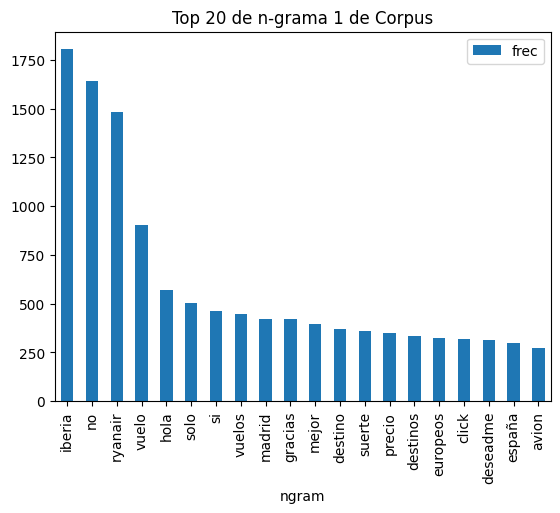

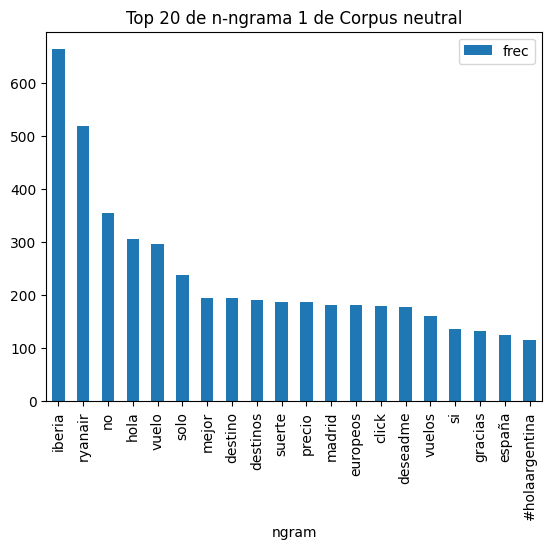

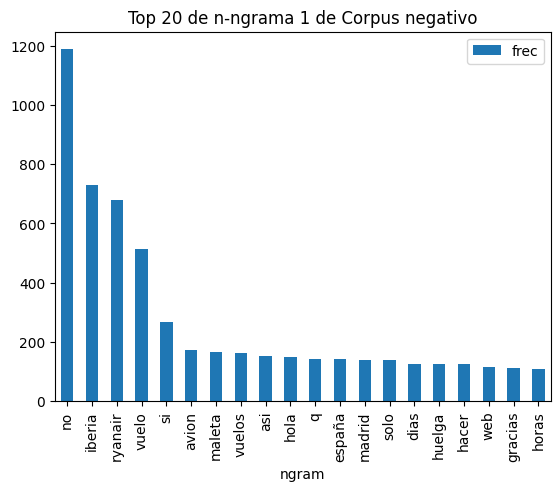

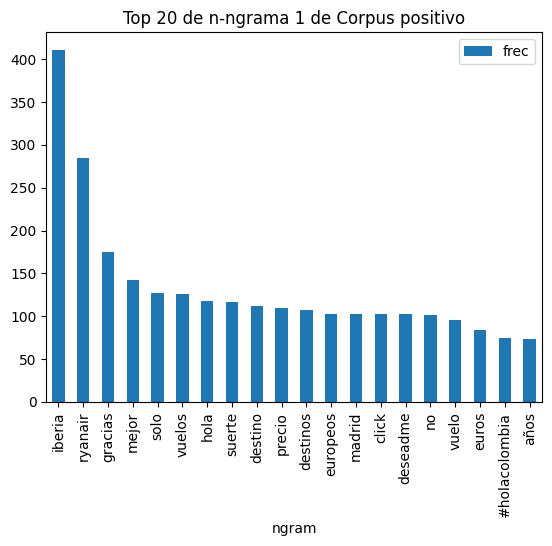

In [6]:
igram, top = 1, 20

# Extraccion de corpus
corpus = ' '.join(prepros_df['pre_text'])
neutral_corpus = ' '.join(prepros_df.loc[prepros_df['airline_sentiment'] == 'neutral', 'pre_text'])
negative_corpus = ' '.join(prepros_df.loc[prepros_df['airline_sentiment'] == 'negative', 'pre_text'])
positive_corpus = ' '.join(prepros_df.loc[prepros_df['airline_sentiment'] == 'positive', 'pre_text'])

top_frec_corpus = top_frec(corpus, igram, top)
top_frec_neutral_corpus = top_frec(neutral_corpus, igram, top)
top_frec_negative_corpus = top_frec(negative_corpus, igram, top)
top_frec_positive_corpus = top_frec(positive_corpus, igram, top)


top_frec_corpus.plot.bar(x='ngram', y='frec', title = f'Top {top} de n-grama {igram} de Corpus');
top_frec_neutral_corpus.plot.bar(x='ngram', y='frec', title = f'Top {top} de n-ngrama {igram} de Corpus neutral');
top_frec_negative_corpus.plot.bar(x='ngram', y='frec', title = f'Top {top} de n-ngrama {igram} de Corpus negativo');
top_frec_positive_corpus.plot.bar(x='ngram', y='frec', title = f'Top {top} de n-ngrama {igram} de Corpus positivo');

Como los tokens `iberia` y `ryanair` son frecuentes en los tres segmentos se eliminaran del conjunto de datos.

In [7]:
no_tokens = ['iberia', 'ryanair', '#iberia', '#ryanair']
prepros_df['pre_text'] = prepros_df['pre_text'].apply(lambda x: remove_tokens(x, no_tokens))

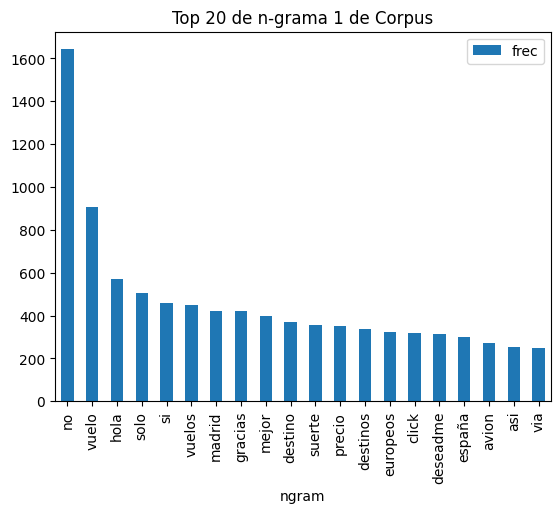

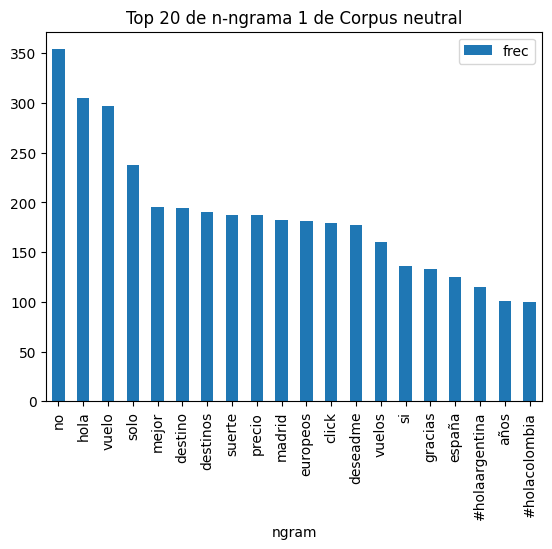

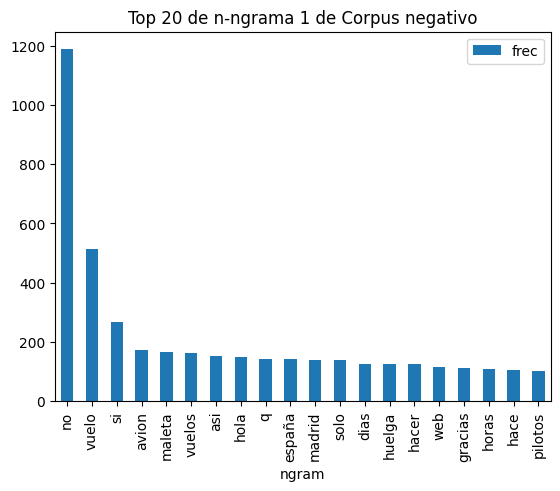

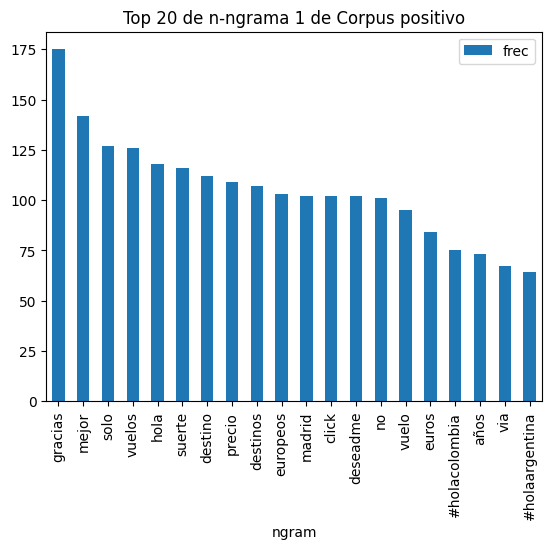

In [8]:
igram, top = 1, 20

# Extraccion de corpus
corpus = ' '.join(prepros_df['pre_text'])
neutral_corpus = ' '.join(prepros_df.loc[prepros_df['airline_sentiment'] == 'neutral', 'pre_text'])
negative_corpus = ' '.join(prepros_df.loc[prepros_df['airline_sentiment'] == 'negative', 'pre_text'])
positive_corpus = ' '.join(prepros_df.loc[prepros_df['airline_sentiment'] == 'positive', 'pre_text'])

top_frec_corpus = top_frec(corpus, igram, top)
top_frec_neutral_corpus = top_frec(neutral_corpus, igram, top)
top_frec_negative_corpus = top_frec(negative_corpus, igram, top)
top_frec_positive_corpus = top_frec(positive_corpus, igram, top)


top_frec_corpus.plot.bar(x='ngram', y='frec', title = f'Top {top} de n-grama {igram} de Corpus');
top_frec_neutral_corpus.plot.bar(x='ngram', y='frec', title = f'Top {top} de n-ngrama {igram} de Corpus neutral');
top_frec_negative_corpus.plot.bar(x='ngram', y='frec', title = f'Top {top} de n-ngrama {igram} de Corpus negativo');
top_frec_positive_corpus.plot.bar(x='ngram', y='frec', title = f'Top {top} de n-ngrama {igram} de Corpus positivo');

In [9]:
prepros_df = prepros_df.loc[prepros_df['pre_text'].str.len() > 0, ['pre_text', 'airline_sentiment']]

In [10]:
prepros_df.to_csv(os.path.join(PROCESSED_PATH, 'processed_tweets.csv'), index=False)

# Entrenamiendo

In [11]:
import numpy as np

# Transformacion de label
from sklearn.preprocessing import LabelEncoder
# Transformacion de texto
from sklearn.feature_extraction.text import CountVectorizer

# Reduccion de dimensionalidad
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.decomposition import PCA
from umap import UMAP

# Clasificacion
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Pipeline
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Separacion de train/val
from sklearn.model_selection import train_test_split

# Evaluacion
from sklearn.metrics import classification_report, f1_score

In [28]:
# Separacion de feautres y labels
label_encoder = LabelEncoder()
X, y = prepros_df['pre_text'], label_encoder.fit_transform(prepros_df['airline_sentiment'])

# Separacion de train/val
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=SEED)

In [22]:
# Definicion de regilla de hiperparametros
param_grid = [
    {'dimension_reduction': [LocallyLinearEmbedding(), PCA(), UMAP()]
    , 'dimension_reduction__n_components': np.power(2, np.linspace(4, 9, 5, dtype = 'int'))
    , 'classifier__max_depth': np.linspace(4, 8, 5, dtype = 'int')}
    ]

In [23]:
# Definicion de pipeline de entrenamiento
pl = Pipeline([
    ('count_vectorizer', CountVectorizer(decode_error = 'ignore'))
    , ('dense_transform', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
    , ('dimension_reduction', LocallyLinearEmbedding())
    , ('classifier', RandomForestClassifier(random_state = SEED))
    ])

In [24]:
# Experimentacion, busqueda de mejores hiperparametros
best_score = 0
i = 0
for parameter in ParameterGrid(param_grid):
    pl.set_params(**parameter)
    pl.fit(X_train, y_train)
    
    y_pred = pl.predict(X_val)
    new_score = f1_score(y_val, y_pred, average ='macro')
    
    if (new_score > best_score) & (new_score < 1):
        best_score = new_score
        best_parameter = parameter
    i += 1
    print(f'Iteracion {i} de {len(ParameterGrid(param_grid))}')

Iteracion 1 de 75
Iteracion 2 de 75
Iteracion 3 de 75
Iteracion 4 de 75
Iteracion 5 de 75
Iteracion 6 de 75
Iteracion 7 de 75
Iteracion 8 de 75
Iteracion 9 de 75
Iteracion 10 de 75


/home/isbelloq/retos/20220917_sentimientos/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Iteracion 11 de 75


/home/isbelloq/retos/20220917_sentimientos/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Iteracion 12 de 75


/home/isbelloq/retos/20220917_sentimientos/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Iteracion 13 de 75


/home/isbelloq/retos/20220917_sentimientos/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Iteracion 14 de 75


/home/isbelloq/retos/20220917_sentimientos/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Iteracion 15 de 75
Iteracion 16 de 75
Iteracion 17 de 75
Iteracion 18 de 75
Iteracion 19 de 75
Iteracion 20 de 75
Iteracion 21 de 75
Iteracion 22 de 75
Iteracion 23 de 75
Iteracion 24 de 75
Iteracion 25 de 75


/home/isbelloq/retos/20220917_sentimientos/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Iteracion 26 de 75


/home/isbelloq/retos/20220917_sentimientos/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Iteracion 27 de 75


/home/isbelloq/retos/20220917_sentimientos/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Iteracion 28 de 75


/home/isbelloq/retos/20220917_sentimientos/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Iteracion 29 de 75


/home/isbelloq/retos/20220917_sentimientos/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Iteracion 30 de 75
Iteracion 31 de 75
Iteracion 32 de 75
Iteracion 33 de 75
Iteracion 34 de 75
Iteracion 35 de 75
Iteracion 36 de 75
Iteracion 37 de 75
Iteracion 38 de 75
Iteracion 39 de 75
Iteracion 40 de 75


/home/isbelloq/retos/20220917_sentimientos/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Iteracion 41 de 75


/home/isbelloq/retos/20220917_sentimientos/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Iteracion 42 de 75


/home/isbelloq/retos/20220917_sentimientos/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Iteracion 43 de 75


/home/isbelloq/retos/20220917_sentimientos/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Iteracion 44 de 75


/home/isbelloq/retos/20220917_sentimientos/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Iteracion 45 de 75
Iteracion 46 de 75
Iteracion 47 de 75
Iteracion 48 de 75
Iteracion 49 de 75
Iteracion 50 de 75
Iteracion 51 de 75
Iteracion 52 de 75
Iteracion 53 de 75
Iteracion 54 de 75
Iteracion 55 de 75


/home/isbelloq/retos/20220917_sentimientos/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Iteracion 56 de 75


/home/isbelloq/retos/20220917_sentimientos/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Iteracion 57 de 75


/home/isbelloq/retos/20220917_sentimientos/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Iteracion 58 de 75


/home/isbelloq/retos/20220917_sentimientos/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Iteracion 59 de 75


/home/isbelloq/retos/20220917_sentimientos/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Iteracion 60 de 75
Iteracion 61 de 75
Iteracion 62 de 75
Iteracion 63 de 75
Iteracion 64 de 75
Iteracion 65 de 75
Iteracion 66 de 75
Iteracion 67 de 75
Iteracion 68 de 75
Iteracion 69 de 75
Iteracion 70 de 75


/home/isbelloq/retos/20220917_sentimientos/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Iteracion 71 de 75


/home/isbelloq/retos/20220917_sentimientos/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Iteracion 72 de 75


/home/isbelloq/retos/20220917_sentimientos/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Iteracion 73 de 75


/home/isbelloq/retos/20220917_sentimientos/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Iteracion 74 de 75


/home/isbelloq/retos/20220917_sentimientos/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Iteracion 75 de 75


In [26]:
# Entrenamiento mejor modelo
best_model = pl.set_params(**best_parameter)
best_model.fit(X_train, y_train)

Pipeline(steps=[('count_vectorizer', CountVectorizer(decode_error='ignore')),
                ('dense_transform',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function <lambda> at 0x7f0bd3923490>)),
                ('dimension_reduction', PCA(n_components=32)),
                ('classifier',
                 RandomForestClassifier(max_depth=8, random_state=123))])

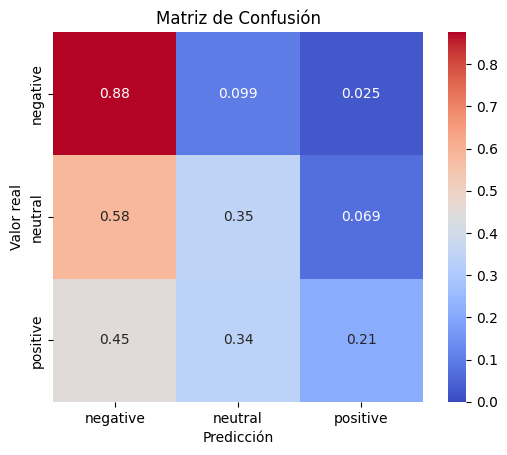

              precision    recall  f1-score   support

           0       0.62      0.88      0.73      1160
           1       0.51      0.35      0.41       765
           2       0.51      0.21      0.30       401

    accuracy                           0.59      2326
   macro avg       0.55      0.48      0.48      2326
weighted avg       0.56      0.59      0.55      2326



In [45]:
# Evaluacion mejor modelo
y_pred = best_model.predict(X_val)

confusion_matrix_heatmap(y_val, y_pred, label_encoder.classes_.tolist(), normalize = 'true')
print(classification_report(y_val, y_pred))